In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("archive.hdf5", 'r')

In [3]:
# wl_min = 5101#5590
# wl_max = 5300#5610

class Spectrum(object): 
    def __init__(self, wl, fl): 
#         wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl#[wl_range]
        self.flux = fl#[wl_range]

(0, 2)

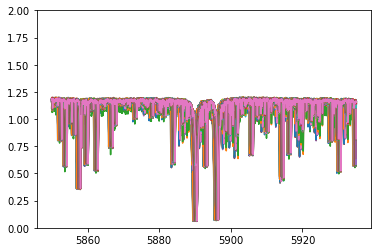

In [4]:
spectra = []
keys = list(archive)
for isot in keys: 
    sp = Spectrum(*archive[isot][:])
    spectra.append(sp)
    
    if sp.flux.max() < 1.2:
        plt.plot(sp.wavelength, sp.flux)

#tio = 5598.410

tio = control = 5208.5 #5603.8 #5594.6 #5602.9 #5593.75 #5594.5

# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 2])

In [5]:
# Expensive, only run once:
dx = []
for i in range(1, len(spectra)):
    cross_corr = np.correlate(spectra[0].flux - np.median(spectra[0].flux), 
                              spectra[i].flux - np.median(spectra[i].flux), mode='same')
    
    dx.append(cross_corr.shape[0]//2 - cross_corr.argmax())

np.save('dx.npy', dx)

# dx = np.load('dx.npy')

In [6]:
from astropy.time import Time
dates = Time(keys, format='isot')

In [7]:
# for i, j in zip(dates.iso, all_fs): 
#     print(i, j)

In [8]:
from json import load
f_S = load(open('f_S.json'))

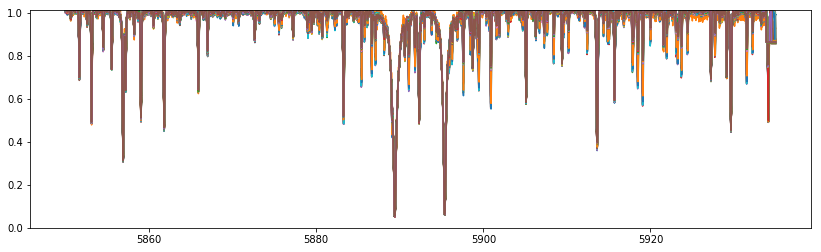

In [35]:
coadded = spectra[0].flux

spectral_grid = spectra[0].flux #np.zeros((len(spectra)-1, len(spectra[0].wavelength)))
all_fs = []

delta_wavelength = np.median(np.abs(np.diff(spectra[0].wavelength)))

spectra_indices = []

plt.figure(figsize=(14, 4))
for i in range(1, len(spectra)): 
    # Quality filter
#     if True:
    if spectra[i].flux.max() < 1.2:
        spectra_indices.append(i)
        date_key = str(dates[i-1].datetime.date())    
        all_fs.append(f_S[date_key])
        wavelength_shift = dx[i-1] * delta_wavelength
    
        rolled_spectrum = np.interp(spectra[0].wavelength, spectra[i].wavelength - wavelength_shift, spectra[i].flux, left=1, right=1)
        rolled_spectrum /= np.median(rolled_spectrum)

        plt.plot(spectra[i].wavelength, rolled_spectrum)
        coadded += rolled_spectrum
        
        spectral_grid = np.vstack([spectral_grid, rolled_spectrum])

coadded /= np.median(coadded)
        
# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 1.01])
spectra_indices = np.array(spectra_indices)

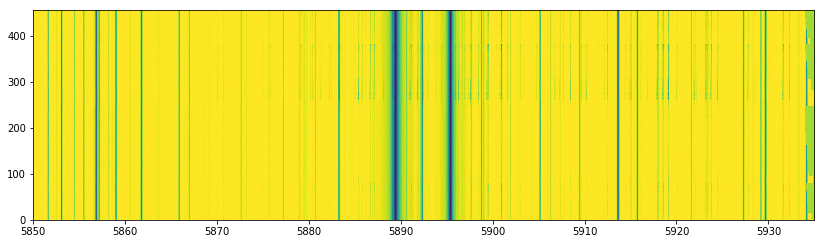

In [33]:
plt.figure(figsize=(14, 14))
extent = [spectra[0].wavelength.min(), spectra[0].wavelength.max(), 
          0, len(spectra_indices)]
plt.imshow(spectral_grid, origin='lower', extent=extent, vmin=0, vmax=1)
plt.gca().set_aspect(0.05)

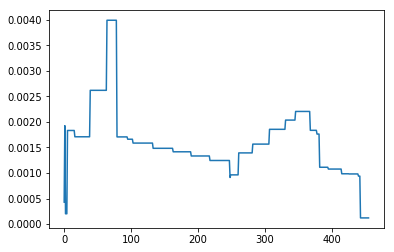

In [14]:
plt.plot(all_fs)

In [15]:
from scipy.stats import pearsonr, spearmanr

r = []
p = []
for i in range(len(spectra[0].wavelength)): 
    ri, pi = spearmanr(spectral_grid[1:, i], all_fs)
    r.append(ri)
    p.append(pi)
    
r = np.array(r)
p = np.array(p)

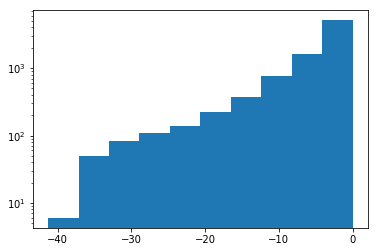

In [16]:
plt.hist(np.log(p), log=True);

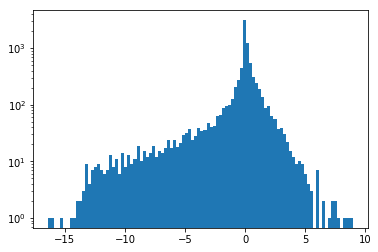

In [36]:
metric = np.array(r) *  -np.log(p)

#flag = np.abs(metric) > 0.35
#flag = metric < -14 #-0.38
flag = metric > 8 #-0.38

ignore_last_100_channels = np.ones(len(spectra[0].wavelength))
ignore_last_100_channels[-100:] = np.zeros(100)

flag *= ignore_last_100_channels.astype(bool)

plt.hist(metric, 100, log=True);

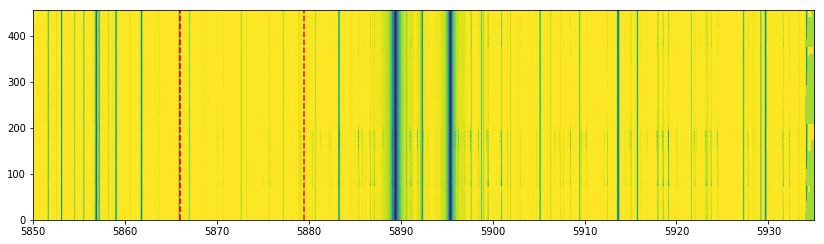

In [37]:
plt.figure(figsize=(14, 14))
plt.imshow(spectral_grid, extent=extent, vmin=0, vmax=1)
for line in spectra[0].wavelength[flag]:
    plt.axvline(line, ls='--', color='r')
plt.gca().set_aspect(0.05)

In [38]:
# for i, j in zip(np.array(keys)[spectra_indices], all_fs):
#     print(i, j)

In [39]:
spectra[0].wavelength.min(), spectra[0].wavelength.max()

(5850.01, 5934.99)

In [40]:
r[flag], p[flag]

(array([0.31700126, 0.3248504 , 0.31869268]),
 array([4.20098488e-12, 1.14666509e-12, 3.18579841e-12]))

In [41]:
from phoenix import get_any_metallicity_url, get_phoenix_model_wavelengths
from astropy.io import fits
from scipy.ndimage import gaussian_filter1d

In [42]:
phoenix_wl = get_phoenix_model_wavelengths()
phoenix_fl = fits.getdata(get_any_metallicity_url(5800, 4.5, 0))
phoenix_fl /= phoenix_fl.max()

wl_min = spectra[0].wavelength.min()
wl_max = spectra[0].wavelength.max()

phoenix_fl = phoenix_fl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]
phoenix_wl = phoenix_wl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]

phoenix_fl /= np.median(phoenix_fl)

In [43]:
import astropy.units as u
#Server: Vienna VALD3 Version: 1949
vald3 = open('/Users/bmmorris/git/whoseline-vis/data/vald3longer.txt').read().splitlines() # Detection threshold : 0.5

#spectral_lines = []
species = []
wavelengths = []
strengths = []
for row in vald3[4:-150]: 
    if row.count(',') > 8:
        split_row = row.split(',')

    species.append(split_row[0][1:-1].strip())
    wavelengths.append(float(split_row[1].strip())*u.Angstrom)
    strengths.append(float(split_row[9].strip()))

species = np.array(species)
wavelengths = u.Quantity(wavelengths)
strengths = np.array(strengths)

from astropy.table import Table

table = Table(dict(species=species, wavelengths=wavelengths, strengths=strengths))

def plot_lines(line_table, axis, n_lines, line_kwargs, upper_xaxis=True):
    wl_bounds = axis.get_xlim()

    rows_within_bounds = ((line_table['wavelengths'] > wl_bounds[0]) & 
                           (line_table['wavelengths'] < wl_bounds[1]))
    
    strengths_within_bounds = line_table[rows_within_bounds]['strengths']
    
    if len(strengths_within_bounds) < n_lines:
        n_lines = len(strengths_within_bounds)
    
    condition = strengths_within_bounds >= np.sort(strengths_within_bounds)[-n_lines]

    for wavelength, strength, species in zip(line_table['wavelengths'][rows_within_bounds][condition],
                                             line_table['strengths'][rows_within_bounds][condition], 
                                             line_table['species'][rows_within_bounds][condition]):
        axis.axvline(wavelength, **line_kwargs)
        if not upper_xaxis:
            axis.annotate(species, xy=(wavelength, 1.0), rotation=30)
        
    new_ticks = line_table['wavelengths'][rows_within_bounds][condition]
    new_tick_labels = line_table['species'][rows_within_bounds][condition]
    
    if upper_xaxis:
        axis_upper = axis.twiny()

        def tick_function(x):
            return (x-wl_bounds[0])/(wl_bounds[1] - wl_bounds[0])

        axis_upper.set_xticks(tick_function(new_ticks))
        axis_upper.set_xticklabels(new_tick_labels, rotation=45, ha='left')

5866.51
5866.52
5880.02


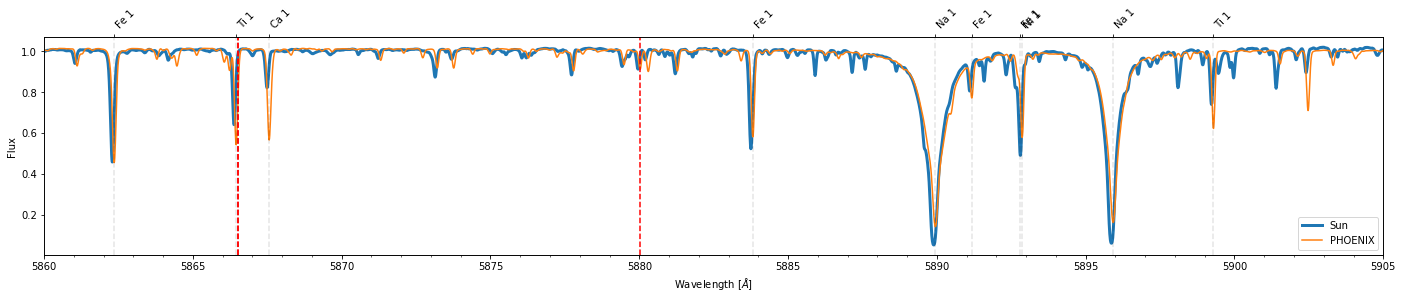

In [45]:
wavelength_offset = 0.49

plt.figure(figsize=(24, 4))
plt.plot(spectra[0].wavelength + wavelength_offset, spectral_grid.sum(axis=0)/np.median(spectral_grid.sum(axis=0)), label='Sun', lw=3)

plt.plot(phoenix_wl, gaussian_filter1d(phoenix_fl, 4), label='PHOENIX')
plt.legend()

for flag_wl in spectra[0].wavelength[flag]:
    print(flag_wl + wavelength_offset)
    plt.axvline(flag_wl + wavelength_offset, ls='--', color='r')
#     plt.xlim([flag_wl-5, flag_wl+5])

# 5174.19 – Mo I
# 5178.0 – Ir I 

# plt.xlim([5170, 5180])

plt.xlim([5860, 5905])


axis = plt.gca()

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
axis.xaxis.set_minor_locator(MultipleLocator(1))

plot_lines(table, axis, 100, dict(ls='--', color='k', alpha=0.1))

axis.set(xlabel='Wavelength [$\AA$]', ylabel='Flux')
plt.savefig('plots/newlines.pdf', bbox_inches='tight')

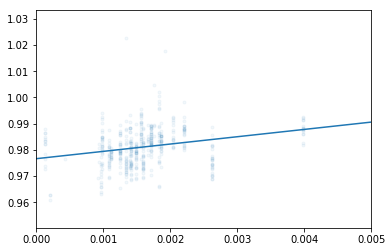

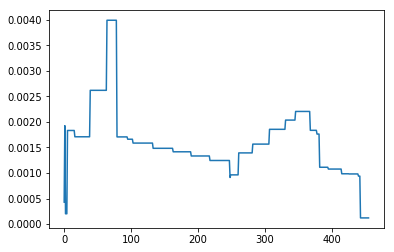

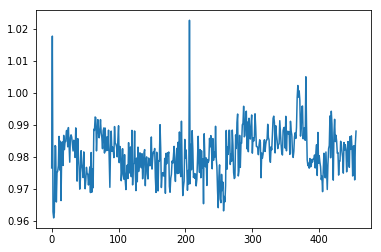

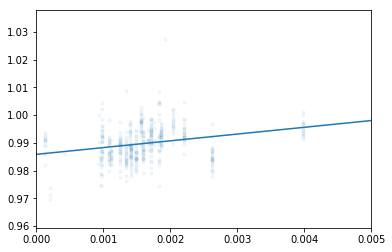

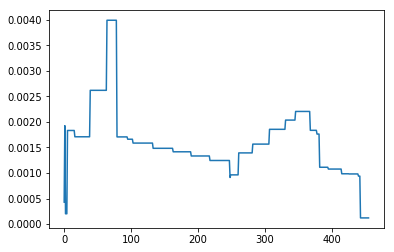

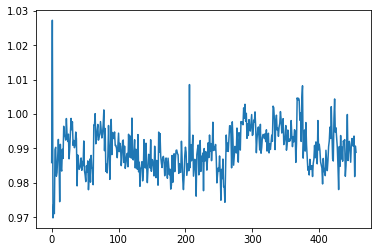

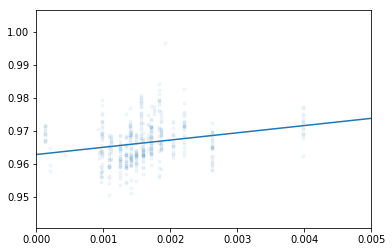

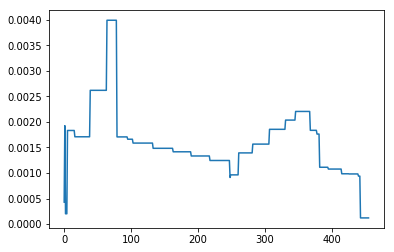

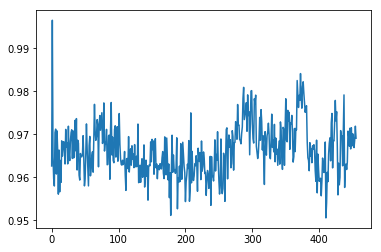

In [46]:
for flag_ind in np.argwhere(flag):
    
    plt.scatter(all_fs, spectral_grid[1:, flag_ind], marker='.', alpha=0.05)

    params = np.polyfit(all_fs, spectral_grid[1:, flag_ind], 1)
    x = np.linspace(0, 0.005)
    y = np.polyval(params, x)

    plt.plot(x, y)

    plt.xlim([0, 0.005])
    
    plt.show()
    
    plt.plot(all_fs)
    plt.show()
    plt.plot(spectral_grid[1:, flag_ind])
    plt.show()
    
    
#     plt.ylim([0.92, 1.0])